In [1]:
# !pip install -q ptflops

In [2]:
#!pip install -r requirements.txt

In [3]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import jaccard_score
import numpy as np
import math
import torch.nn.functional as F
import torchvision
import time
import pandas as pd
import datetime
import random
import sys
import cv2  # morphology를 위해 추가

In [4]:
# # 기본 디렉토리 설정 
# TRAIN_DIR = "/kaggle/input/2025-sw-ai/archive/train"
# VAL_DIR = "/kaggle/input/2025-sw-ai/archive/val"
# TEST_DIR = "/kaggle/input/2025-sw-ai/archive/test/images"
# OUTPUT_PATH = "/kaggle/working/submission.csv"

In [5]:
# 로컬 디렉토리 설정
TRAIN_DIR = "input/2025-csu-sw-ai-challenge/archive/train" 
VAL_DIR = "input/2025-csu-sw-ai-challenge/archive/val"
TEST_DIR = "input/2025-csu-sw-ai-challenge/archive/test/images"
OUTPUT_CSV = "working/submission.csv" 
OUTPUT_MASK = "working/mask_ouputs"

In [ ]:
# 디렉토리 설정
TRAIN_DIR = "/home/work/kaggle_crack_seg1/dataset/archive/train" 
VAL_DIR = "/home/work/kaggle_crack_seg1/dataset/archive/val"
TEST_DIR = "/home/work/kaggle_crack_seg1/dataset/archive/test/images"
OUTPUT_CSV = "working/submission.csv" 
OUTPUT_MASK = "working/mask_ouputs"

In [6]:
SEED = 2025
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'set SEED: {SEED}')
set_seed()

set SEED: 2025


In [7]:
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate,
    RandomBrightnessContrast, GaussNoise, OneOf, Blur, MotionBlur, RandomGamma,
    CLAHE, Sharpen, GridDistortion, ElasticTransform, CoarseDropout, ISONoise
)
from albumentations.pytorch import ToTensorV2

def get_transform():
    """
    강력한 데이터 증강 파이프라인
    """
    return Compose([
        # 기하학적 변환
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        ShiftScaleRotate(shift_limit=0.08, scale_limit=0.2, rotate_limit=45, p=0.6),
        # Edge-preserving 증강
        OneOf([
            GridDistortion(p=1.0, distort_limit=0.1),
            ElasticTransform(p=1.0, alpha=50, sigma=7, alpha_affine=7),
        ], p=0.3),
        # 노이즈 추가
        OneOf([
            GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
        ], p=0.4),
        # 블러링
        OneOf([
            Blur(blur_limit=3, p=1.0),
            MotionBlur(blur_limit=5, p=1.0),
        ], p=0.3),
        # 밝기/대비 조정
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.3),
        # CLAHE로 대비 향상
        CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.4),
        # Sharpen으로 미세 구조 강조
        Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.3),
        # CoarseDropout으로 robustness 향상
        CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
        ToTensorV2()
    ])

def mixup_data(x, y, alpha=0.4):
    """
    Mixup 데이터 증강
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]
    return mixed_x, mixed_y

def cutmix_data(x, y, alpha=1.0):
    """
    CutMix 데이터 증강
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    _, _, H, W = x.size()
    cut_rat = np.sqrt(1. - lam)
    cut_h = int(H * cut_rat)
    cut_w = int(W * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    y[:, :, bby1:bby2, bbx1:bbx2] = y[index, :, bby1:bby2, bbx1:bbx2]
    return x, y

import os
import glob
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
import cv2

class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment_ratio=1, apply_clahe=False):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.img_list = sorted(glob.glob(self.img_dir + "/*.jpg"))
        self.mask_list = sorted(glob.glob(self.mask_dir + "/*.jpg"))
        self.transform = transform
        self.augment_ratio = max(1, augment_ratio)
        self.apply_clahe = apply_clahe

    def __len__(self):
        return len(self.img_list) * self.augment_ratio

    def __getitem__(self, idx):
        original_count = len(self.img_list)
        if idx < original_count:
            img = Image.open(self.img_list[idx]).convert("L")
            mask = Image.open(self.mask_list[idx]).convert("L")
            img = np.array(img, dtype=np.float32) / 255.0
            mask = np.array(mask, dtype=np.float32) / 255.0
            mask = (mask > 0.5).astype(np.float32)
            if self.apply_clahe:
                img_uint8 = (img * 255).astype(np.uint8)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                img_uint8 = clahe.apply(img_uint8)
                img = img_uint8.astype(np.float32) / 255.0

            # 1채널을 3채널로 복제
            img = np.stack([img]*3, axis=-1)

            img = torch.tensor(img).permute(2, 0, 1)  # (H,W,C)->(C,H,W)
            img = img[:1, :, :]  # 다시 1채널로 변환하여 모델 입력에 맞춤
            mask = torch.tensor(mask).unsqueeze(0)
            return img, mask

        else:
            aug_idx = idx - original_count
            orig_idx = aug_idx % original_count
            img = Image.open(self.img_list[orig_idx]).convert("L")
            mask = Image.open(self.mask_list[orig_idx]).convert("L")
            img = np.array(img, dtype=np.float32) / 255.0
            mask = np.array(mask, dtype=np.float32) / 255.0
            mask = (mask > 0.5).astype(np.float32)
            if self.apply_clahe:
                img_uint8 = (img * 255).astype(np.uint8)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                img_uint8 = clahe.apply(img_uint8)
                img = img_uint8.astype(np.float32) / 255.0

            # 3채널 복제
            img = np.stack([img]*3, axis=-1)

            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask'].unsqueeze(0).float()
                img = img[:1, :, :]  # 1채널로 변환하여 모델 입력에 맞춤
            else:
                img = torch.tensor(img).permute(2, 0, 1)
                img = img[:1, :, :]
                mask = torch.tensor(mask).unsqueeze(0).float()

            return img, mask



/usr/local/lib/python3.12/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
class HrSegNetB16(nn.Module):
    def __init__(self,
                 in_channels=1,  # input channel
                 base=16,  # base channel of the model, 
                 num_classes=1,  # number of classes
                 pretrained=None  # pretrained model
                 ):
        super(HrSegNetB16, self).__init__()
        self.base = base
        self.num_classes = num_classes
        self.pretrained = pretrained
        # Stage 1 and 2 constitute the stem of the model, which is mainly used to extract low-level features.
        # Meanwhile, stage1 and 2 reduce the input image to 1/2 and 1/4 of the original size respectively
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=base // 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base // 2),
            nn.ReLU(),
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=base // 2, out_channels=base, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU(),
        )
        
        self.seg1 = SegBlock(base=base, stage_index=1)
        self.seg2 = SegBlock(base=base, stage_index=2)
        self.seg3 = SegBlock(base=base, stage_index=3)

        self.aux_head1 = SegHead(inplanes=base, interplanes=base, outplanes=num_classes, aux_head=True)
        self.aux_head2 = SegHead(inplanes=base, interplanes=base, outplanes=num_classes, aux_head=True)
        self.head = SegHead(inplanes=base, interplanes=base, outplanes=num_classes)

        self.init_weight()
    
    def forward(self, x):
        logit_list = []
        h, w = x.shape[2:]
        # aux_head only used in training
        if self.training:
            stem1_out = self.stage1(x)
            stem2_out = self.stage2(stem1_out)
            hrseg1_out = self.seg1(stem2_out)
            hrseg2_out = self.seg2(hrseg1_out)
            hrseg3_out = self.seg3(hrseg2_out)
            last_out = self.head(hrseg3_out)
            seghead1_out = self.aux_head1(hrseg1_out)
            seghead2_out = self.aux_head2(hrseg2_out)
            logit_list = [last_out, seghead1_out, seghead2_out]
            logit_list = [F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=True) for logit in logit_list]
            return logit_list
        else:
            stem1_out = self.stage1(x)
            stem2_out = self.stage2(stem1_out)
            hrseg1_out = self.seg1(stem2_out)
            hrseg2_out = self.seg2(hrseg1_out)
            hrseg3_out = self.seg3(hrseg2_out)
            last_out = self.head(hrseg3_out)
            logit_list = [last_out]
            logit_list = [F.interpolate(logit, size=(h, w), mode='bilinear', align_corners=True) for logit in logit_list]
            return logit_list
        
    
    def init_weight(self):
        if self.pretrained is not None:
            pass
        else:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
    
class SegBlock(nn.Module):
    def __init__(self, base=32, stage_index=1):
        super(SegBlock, self).__init__()

        # Convolutional layer for high-resolution paths with constant spatial resolution and constant channel
        self.h_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )
        self.h_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )
        self.h_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base, out_channels=base, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU()
        )

        # Semantic guidance path/low-resolution path
        if stage_index == 1:  # First stage, stride=2, spatial resolution/2, channel*2
            self.l_conv1 = nn.Sequential(
                nn.Conv2d(in_channels=base, out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        elif stage_index == 2:  # Second stage
            self.l_conv1 = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=base, out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        elif stage_index == 3:
            self.l_conv1 = nn.Sequential(
                nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=base, out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
                nn.ReLU(),
                nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
                nn.ReLU()
            )
        else:
            raise ValueError("stage_index must be 1, 2 or 3")
        self.l_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
            nn.ReLU()
        )
        self.l_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base * int(math.pow(2, stage_index)), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base * int(math.pow(2, stage_index))),
            nn.ReLU()
        )

        self.l2h_conv1 = nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)
        self.l2h_conv2 = nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)
        self.l2h_conv3 = nn.Conv2d(in_channels=base * int(math.pow(2, stage_index)), out_channels=base, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        size = x.shape[2:]
        out_h1 = self.h_conv1(x)  # high resolution path
        out_l1 = self.l_conv1(x)  # low resolution path
        out_l1_i = F.interpolate(out_l1, size=size, mode='bilinear', align_corners=True)  # upsample
        out_hl1 = self.l2h_conv1(out_l1_i) + out_h1  # low to high

        out_h2 = self.h_conv2(out_hl1)
        out_l2 = self.l_conv2(out_l1)
        out_l2_i = F.interpolate(out_l2, size=size, mode='bilinear', align_corners=True)
        out_hl2 = self.l2h_conv2(out_l2_i) + out_h2

        out_h3 = self.h_conv3(out_hl2)
        out_l3 = self.l_conv3(out_l2)
        out_l3_i = F.interpolate(out_l3, size=size, mode='bilinear', align_corners=True)
        out_hl3 = self.l2h_conv3(out_l3_i) + out_h3
        return out_hl3

# seg head
class SegHead(nn.Module):
    def __init__(self, inplanes, interplanes, outplanes, aux_head=False):
        super(SegHead, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU()
        if aux_head:
            self.con_bn_relu = nn.Sequential(
                nn.Conv2d(in_channels=inplanes, out_channels=interplanes, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(interplanes),
                nn.ReLU(),
            )
        else:
            self.con_bn_relu = nn.Sequential(
                nn.ConvTranspose2d(in_channels=inplanes, out_channels=interplanes, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(interplanes),
                nn.ReLU(),
            )
        self.conv = nn.Conv2d(in_channels=interplanes, out_channels=outplanes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.bn1(x)
        x = self.relu(x)
        x = self.con_bn_relu(x)
        out = self.conv(x)
        return out

In [9]:
def binary_metrics(preds, targets, eps=1e-6):
    preds = preds.float()
    targets = targets.float()

    tp = (preds * targets).sum(dim=(1,2,3))
    fp = (preds * (1 - targets)).sum(dim=(1,2,3))
    fn = ((1 - preds) * targets).sum(dim=(1,2,3))

    precision = (tp + eps) / (tp + fp + eps)
    recall    = (tp + eps) / (tp + fn + eps)
    f1        = (2 * precision * recall + eps) / (precision + recall + eps)  # Dice
    union     = tp + fp + fn
    iou       = (tp + eps) / (union + eps)

    return {
        "iou": iou.mean().item(),
        "precision": precision.mean().item(),
        "recall": recall.mean().item(),
        "f1": f1.mean().item(),
    }

In [10]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-6):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        return (alpha_t * focal_weight * bce_loss).mean()

# Lovasz Loss
def lovasz_grad(gt_sorted):
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if len(jaccard) > 1:
        jaccard[1:] = jaccard[1:] - jaccard[:-1]
    return jaccard

class LovaszLoss(nn.Module):
    def forward(self, logits, targets):
        probs_flat = torch.sigmoid(logits).view(-1)
        targets_flat = targets.view(-1)
        errors, perm = torch.sort((probs_flat - targets_flat).abs(), descending=True)
        grad = lovasz_grad(targets_flat[perm])
        return torch.dot(errors, grad)

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits).view(-1)
        targets_flat = targets.view(-1)
        intersection = (probs * targets_flat).sum()
        dice = (2 * intersection + self.smooth) / (probs.sum() + targets_flat.sum() + self.smooth)
        return 1 - dice

# BCE + Dice Loss
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
    def forward(self, logits, targets):
        return self.bce_weight * self.bce(logits, targets) + self.dice_weight * self.dice(logits, targets)

# F-beta Loss
class FbetaLoss(nn.Module):
    def __init__(self, beta=2.0, smooth=1e-6):
        super(FbetaLoss, self).__init__()
        self.beta = beta
        self.smooth = smooth
    def forward(self, logits, targets):
        preds = torch.sigmoid(logits)
        tp = (preds * targets).sum(dim=(2,3))
        fp = (preds * (1-targets)).sum(dim=(2,3))
        fn = ((1-preds) * targets).sum(dim=(2,3))
        beta2 = self.beta**2
        f_beta = ((1+beta2)*tp + self.smooth) / ((1+beta2)*tp + beta2*fn + fp + self.smooth)
        return 1 - f_beta.mean()


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time

# --- [추가] F-beta 점수 계산 함수 (검증용) ---
def calculate_fbeta(preds, masks, beta=2.0, smooth=1e-6):
    preds = preds.float()
    masks = masks.float()

    # 배치 전체를 하나의 큰 이미지로 보고 계산
    tp = (preds * masks).sum()
    fp = (preds * (1 - masks)).sum()
    fn = ((1 - preds) * masks).sum()
    
    beta2 = beta ** 2
    f_beta = ((1 + beta2) * tp + smooth) / ((1 + beta2) * tp + beta2 * fn + fp + smooth)
    
    return f_beta.item()

# --- [적용] 사용자께서 제공하신 binary_metrics 함수 ---
def binary_metrics(preds, targets, eps=1e-6):
    preds = preds.float()
    targets = targets.float()

    # 배치 내 각 샘플에 대해 TP, FP, FN 계산
    tp = (preds * targets).sum(dim=(1,2,3))
    fp = (preds * (1 - targets)).sum(dim=(1,2,3))
    fn = ((1 - preds) * targets).sum(dim=(1,2,3))

    precision = (tp + eps) / (tp + fp + eps)
    recall    = (tp + eps) / (tp + fn + eps)
    f1        = (2 * precision * recall + eps) / (precision + recall + eps)
    union     = tp + fp + fn
    iou       = (tp + eps) / (union + eps)

    # 각 지표를 배치에 대해 평균내어 반환
    return {
        "iou": iou.mean().item(),
        "precision": precision.mean().item(),
        "recall": recall.mean().item(),
        "f1": f1.mean().item(),
    }



In [12]:
import time

def train_model(
    model, train_loader, val_loader, device,
    epochs=100, aux_weights=(1.0,0.4,0.4), lr=1e-3,
    use_amp=True, log_every=500, validate_every_steps=None,
    threshold=0.5, patience=12, model_save_path='best_model.pth',
    loss_fn='focal', scheduler_type='cosine',
    use_mixup=False, use_cutmix=False, mixup_alpha=0.4, cutmix_alpha=1.0
):
    model.to(device)
    # 손실함수 선택
    if loss_fn=='focal':
        criterion=FocalLoss()
    elif loss_fn=='lovasz':
        criterion=LovaszLoss()
    elif loss_fn=='bce_dice':
        criterion=BCEDiceLoss()
    elif loss_fn=='fbeta':
        criterion=FbetaLoss()
    else:
        criterion=FbetaLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # 스케줄러 선택
    if scheduler_type=='cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    elif scheduler_type=='onecycle':
        total_steps = epochs * len(train_loader)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=total_steps, pct_start=0.3)
    else:
        scheduler = None
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    patience_counter=0
    best_val_fbeta=0.0
    best_threshold=threshold

    global_step=0
    win_loss = 0.0
    win_iou = 0.0
    win_f1 = 0.0
    win_steps = 0

    t0_epoch = time.time()

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        t0_step = time.time()

        for imgs, masks in train_loader:
            global_step += 1
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            if use_mixup and np.random.rand() < 0.5:
                imgs, masks = mixup_data(imgs, masks, alpha=mixup_alpha)
            elif use_cutmix and np.random.rand() < 0.5:
                imgs, masks = cutmix_data(imgs, masks, alpha=cutmix_alpha)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(imgs)
                main_logit = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
                loss = aux_weights[0] * criterion(main_logit, masks)
                if isinstance(outputs, (list, tuple)):
                    if len(outputs) > 1:
                        loss += aux_weights[1] * criterion(outputs[1], masks)
                    if len(outputs) > 2:
                        loss += aux_weights[2] * criterion(outputs[2], masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if scheduler_type == 'onecycle' and scheduler is not None:
                scheduler.step()

            epoch_loss += loss.item()

            # 지표 계산
            with torch.no_grad():
                probs = torch.sigmoid(main_logit)
                preds = (probs > threshold).float()
                metrics = binary_metrics(preds, masks)

            win_loss += loss.item()
            win_iou += metrics['iou']
            win_f1 += metrics['f1']
            win_steps += 1

            # 로그 출력
            if log_every and (global_step % log_every == 0):
                elapsed = time.time() - t0_step
                print(f"[Step {global_step}] epoch={epoch}  avg_loss(win)={win_loss/win_steps:.4f}  "
                      f"avg_iou(win)={win_iou/win_steps:.4f}  avg_f1(win)={win_f1/win_steps:.4f}  "
                      f"lr={optimizer.param_groups[0]['lr']:.3e}  elapsed={elapsed:.1f}s")
                win_loss = 0.0
                win_iou = 0.0
                win_f1 = 0.0
                win_steps = 0
                t0_step = time.time()

        # epoch 종료 후 스케줄러 업데이트 (cosine)
        if scheduler_type == 'cosine' and scheduler is not None:
            scheduler.step()

        avg_train_loss = epoch_loss / len(train_loader)
        # 검증
        model.eval()
        val_losses, val_fbetas, val_ious, val_f1s = [], [], [], []
        all_probs, all_masks = [], []
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)
                outputs = model(imgs)
                main_logit = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
                val_loss = criterion(main_logit, masks)
                val_losses.append(val_loss.item())

                probs = torch.sigmoid(main_logit)
                all_probs.append(probs.cpu().numpy())
                all_masks.append(masks.cpu().numpy())

                preds = (probs > threshold).float()
                metrics = binary_metrics(preds, masks)
                val_ious.append(metrics['iou'])
                val_f1s.append(metrics['f1'])

                fbeta_score = calculate_fbeta(preds, masks)
                val_fbetas.append(fbeta_score)

        all_probs = np.concatenate(all_probs, axis=0)
        all_masks = np.concatenate(all_masks, axis=0)

        best_score = 0
        best_epoch_thr = best_threshold
        for t in np.linspace(0, 0.99, 200):
            preds_bin = (all_probs > t).astype(np.uint8)
            tp = (preds_bin * all_masks).sum(axis=(1, 2, 3))
            fp = (preds_bin * (1 - all_masks)).sum(axis=(1, 2, 3))
            fn = ((1 - preds_bin) * all_masks).sum(axis=(1, 2, 3))
            f2 = ((1 + 4) * tp + 1e-6) / ((1 + 4) * tp + 4 * fn + fp + 1e-6)
            score = f2.mean()
            if score > best_score:
                best_score = score
                best_epoch_thr = t

        avg_val_loss = np.mean(val_losses)
        avg_val_iou = np.mean(val_ious)
        avg_val_f1 = np.mean(val_f1s)
        avg_val_fbeta = np.mean(val_fbetas)

        print(f"[Epoch {epoch}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val IoU: {avg_val_iou:.4f} | "
              f"Val F1: {avg_val_f1:.4f} | "
              f"Val F-beta(β=2.0): {avg_val_fbeta:.4f} | "
              f"Best Threshold: {best_epoch_thr:.3f} | "
              f"Best F-beta@threshold: {best_score:.4f}")

        if best_score > best_val_fbeta:
            best_val_fbeta = best_score
            best_threshold = best_epoch_thr
            torch.save(model.state_dict(), model_save_path)
            print(" -> Best score updated. Model saved.")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f" -> Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {patience} epochs without improvement.")
                break

    model.load_state_dict(torch.load(model_save_path))
    return model, best_threshold


In [13]:
train_dataset = CrackDataset(TRAIN_DIR, transform=get_transform(), augment_ratio=3, apply_clahe=True)
val_dataset   = CrackDataset(VAL_DIR,   transform=None, augment_ratio=1, apply_clahe=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_41129/320705489.py:21: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  ElasticTransform(p=1.0, alpha=50, sigma=7, alpha_affine=7),
/tmp/ipykernel_41129/320705489.py:25: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  GaussNoise(var_limit=(10.0, 50.0), p=1.0),
/tmp/ipykernel_41129/320705489.py:41: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),


In [14]:
from ptflops import get_model_complexity_info

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HrSegNetB16(in_channels=1, num_classes=1).to(device)
input_size = (1, 192, 192)

macs, params = get_model_complexity_info(model,
                                         input_size,
                                         as_strings=True,
                                         print_per_layer_stat=False,
                                         verbose=False)
print(f"Total Params: {params}")
print(f"Total MACs: {macs}")

Total Params: 609.75 k
Total MACs: 130.86 MMac


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model, best_threshold = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=100,
    lr=1e-3,
    use_amp=True,
    loss_fn='focal',
    scheduler_type='cosine',
    use_mixup=True,
    use_cutmix=True,
    mixup_alpha=0.4,
    patience=12
)

cuda


/tmp/ipykernel_41129/3760524442.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_41129/3760524442.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[Step 500] epoch=1  avg_loss(win)=0.0339  avg_iou(win)=0.0960  avg_f1(win)=0.1048  lr=1.000e-03  elapsed=19.3s
[Step 1000] epoch=1  avg_loss(win)=0.0246  avg_iou(win)=0.0970  avg_f1(win)=0.0996  lr=1.000e-03  elapsed=18.3s
[Step 1500] epoch=1  avg_loss(win)=0.0224  avg_iou(win)=0.1017  avg_f1(win)=0.1065  lr=1.000e-03  elapsed=18.1s
[Step 2000] epoch=1  avg_loss(win)=0.0211  avg_iou(win)=0.1114  avg_f1(win)=0.1206  lr=1.000e-03  elapsed=18.1s
[Step 2500] epoch=1  avg_loss(win)=0.0196  avg_iou(win)=0.0968  avg_f1(win)=0.1127  lr=1.000e-03  elapsed=18.1s
[Epoch 1/100] Train Loss: 0.0238 | Val Loss: 0.0091 | Val IoU: 0.2065 | Val F1: 0.2382 | Val F-beta(β=2.0): 0.0677 | Best Threshold: 0.269 | Best F-beta@threshold: 0.4665
 -> Best score updated. Model saved.
[Step 3000] epoch=2  avg_loss(win)=0.0197  avg_iou(win)=0.1006  avg_f1(win)=0.1189  lr=9.998e-04  elapsed=6.6s
[Step 3500] epoch=2  avg_loss(win)=0.0182  avg_iou(win)=0.1166  avg_f1(win)=0.1434  lr=9.998e-04  elapsed=18.5s
[Step 4000

In [16]:
def save_mask_image(
    mask_image: Image.Image,
    base_output_dir: str,
    original_filename: str,
    script_name: str = 'defalut'
):
    """
    마스크 이미지를 지정된 규칙에 따라 폴더를 생성하고 저장합니다.

    Args:
        mask_image (Image.Image): 저장할 PIL 이미지 객체.
        base_output_dir (str): 결과 폴더를 생성할 상위 경로.
        original_filename (str): 원본 이미지 파일명 (e.g., 'image_001.jpg').
        script_name (str): 현재 실행 중인 파이썬 스크립트 또는 노트북 파일명.
    
    Returns:
        str: 파일이 저장된 전체 경로.
    """
    # 1. 'test_파일명_mmddhhmm' 형식으로 폴더명 생성
    now = datetime.datetime.now()
    timestamp = now.strftime("%m%d%H%M")  # mmddhhmm 형식
    
    # 스크립트 이름에서 확장자(.py, .ipynb) 제거
    script_basename = os.path.splitext(script_name)[0]
    
    folder_name = f"test_{script_basename}_{timestamp}"
    output_dir = os.path.join(base_output_dir, folder_name)
    
    # 폴더 생성 (이미 존재하면 그대로 사용)
    os.makedirs(output_dir, exist_ok=True)

    # 2. 저장할 파일명 생성 (원본 파일명 기반)
    original_basename = os.path.splitext(original_filename)[0]
    output_filename = f"{original_basename}_mask.png"
    
    # 3. 전체 저장 경로를 조합하고 이미지 저장
    output_path = os.path.join(output_dir, output_filename)
    mask_image.save(output_path)
    
    return output_path

In [17]:
def post_process_mask(mask, kernel_size=3, iterations=1):
    """
    Morphological operations로 잡음 제거 및 균열 연결 강화
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel, iterations=iterations)
    return mask_opened

def predict_with_tta(model, img_tensor, device, threshold=0.5, apply_tta=True):
    """
    Test-Time Augmentation 예측
    """
    model.eval()
    if not apply_tta:
        with torch.no_grad():
            out=model(img_tensor.to(device))
            logit = out[0] if isinstance(out,(list,tuple)) else out
            prob = torch.sigmoid(logit)[0,0].cpu().numpy()
        return (prob>threshold).astype(np.uint8)

    predictions=[]
    with torch.no_grad():
        # 1. 원본
        out=model(img_tensor.to(device))
        prob=torch.sigmoid(out[0] if isinstance(out,(list,tuple)) else out)[0,0].cpu().numpy()
        predictions.append(prob)
        # 2. 좌우반전
        img_h=torch.flip(img_tensor,dims=[3])
        prob_h=torch.sigmoid(model(img_h.to(device))[0])[0,0].cpu().numpy()
        predictions.append(np.fliplr(prob_h))
        # 3. 상하반전
        img_v=torch.flip(img_tensor,dims=[2])
        prob_v=torch.sigmoid(model(img_v.to(device))[0])[0,0].cpu().numpy()
        predictions.append(np.flipud(prob_v))
        # 4~6. 회전 90,180,270
        for k in [1,2,3]:
            img_r=torch.rot90(img_tensor,k=k,dims=[2,3])
            prob_r=torch.sigmoid(model(img_r.to(device))[0])[0,0].cpu().numpy()
            predictions.append(np.rot90(prob_r,k=-k))
    avg_prob=np.mean(predictions,axis=0)
    return (avg_prob>threshold).astype(np.uint8)


In [18]:
def rle_encode(mask):
    """
    mask: 2D numpy array of {0,1}, shape (H,W)
    return: run length as string
    """
    pixels = mask.flatten(order="C")
    ones = np.where(pixels == 1)[0] + 1  # 1-based
    if len(ones) == 0:
        return ""
    runs = []
    prev = -2
    for idx in ones:
        if idx > prev + 1:
            runs.extend((idx, 0))
        runs[-1] += 1
        prev = idx
    return " ".join(map(str, runs))


In [19]:
def predict_submit_and_save_masks(
    model, test_img_dir, output_csv, device,
    threshold=0.5, save_masks=False, mask_save_dir=None,
    apply_tta=True, apply_morphology=True,
    morph_kernel_size=3, morph_iterations=1
):
    model.eval()
    model.to(device)
    ids, rles = [], []
    output_mask_path = ""

    if save_masks:
        if mask_save_dir is None:
            raise ValueError("mask_save_dir 필요")
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_mask_path = os.path.join(mask_save_dir, f"predictions_{timestamp}")
        os.makedirs(output_mask_path, exist_ok=True)
        print(f"Mask images will be saved to: {output_mask_path}")

    test_imgs = sorted(glob.glob(os.path.join(test_img_dir, "*.jpg")))
    for i, path in enumerate(test_imgs):
        img_id = os.path.splitext(os.path.basename(path))[0]
        img = Image.open(path).convert("L")
        arr = np.array(img, dtype=np.float32) / 255.0
        tensor = torch.tensor(arr).unsqueeze(0).unsqueeze(0).to(device)
        pred = predict_with_tta(model, tensor, device, threshold, apply_tta)
        if apply_morphology:
            pred = post_process_mask(pred, morph_kernel_size, morph_iterations)
        if save_masks:
            mask_img = Image.fromarray((pred * 255).astype(np.uint8), mode='L')
            mask_img.save(os.path.join(output_mask_path, f"{img_id}_mask.png"))
        ids.append(img_id)
        rles.append(rle_encode(pred))

    df = pd.DataFrame({"image_id": ids, "rle": rles})
    df.to_csv(output_csv, index=False)
    print(f"OK. Submission CSV saved to {output_csv}, total {len(df)} rows.")
    if save_masks:
        print(f"OK. Mask images also saved in: {output_mask_path}")


In [20]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def _to_numpy01(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().float()
        if x.ndim == 3 and x.shape[0] in (1,3):  # (C,H,W) -> (H,W)
            x = x[0]
        elif x.ndim == 4:  # (B,1,H,W) -> first item
            x = x[0,0]
        elif x.ndim == 2:
            pass
        else:
            raise ValueError(f"Unexpected tensor shape: {tuple(x.shape)}")
        x = x.numpy()
    else:
        x = np.array(x)
        if x.ndim == 3 and x.shape[0] in (1,3):
            x = x[0]
        elif x.ndim != 2:
            raise ValueError(f"Unexpected array shape: {tuple(x.shape)}")
    # normalize to [0,1]
    x = x.astype(np.float32)
    if x.max() > 1.0:
        x = x / 255.0
    x = np.clip(x, 0.0, 1.0)
    return x

def overlay_red_blue(gray01, gt01, pred01, alpha=0.45):
    H, W = gray01.shape
    base = np.stack([gray01, gray01, gray01], axis=-1)  # to RGB [0,1]

    # color layers
    red  = np.zeros_like(base); red[...,0] = 1.0               # (1,0,0)
    blue = np.zeros_like(base); blue[...,2] = 1.0              # (0,0,1)

    out = base.copy()
    # apply GT (red)
    gt_mask = gt01.astype(bool)
    out[gt_mask] = (1 - alpha) * out[gt_mask] + alpha * red[gt_mask]
    # apply Pred (blue)
    pred_mask = pred01.astype(bool)
    out[pred_mask] = (1 - alpha) * out[pred_mask] + alpha * blue[pred_mask]

    # convert to uint8
    out = (np.clip(out, 0, 1) * 255).astype(np.uint8)
    return out

@torch.no_grad()
def visualize_batch(model, loader, device="cuda", n=8, thresh=0.5, save_dir=None, title_prefix="Train"):
    model.eval()
    device = torch.device(device if torch.cuda.is_available() and device=="cuda" else "cpu")
    model.to(device)

    batch = next(iter(loader))
    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
        imgs, gts = batch[0], batch[1]
        img_paths = None
    elif isinstance(batch, dict):
        imgs, gts = batch["image"], batch["mask"]
        img_paths = batch.get("path", None)
    else:
        raise ValueError("Loader batch format not understood. Expecting (images, masks).")

    imgs = imgs.to(device)  # (B,1,H,W) or (B,H,W)
    # forward
    preds = model(imgs)
    # make sure shape is (B,1,H,W)


    if isinstance(preds, dict):
        for k in ["out", "logits", "pred", "preds"]:
            if k in preds and isinstance(preds[k], torch.Tensor):
                preds = preds[k]
                break
        else:
            preds = next(v for v in preds.values() if isinstance(v, torch.Tensor))
    
    elif isinstance(preds, (list, tuple)):
        for v in reversed(preds):
            if isinstance(v, torch.Tensor):
                preds = v
                break
        else:
            raise ValueError("No tensor found in model outputs list/tuple.")
    
    if not isinstance(preds, torch.Tensor):
        raise TypeError(f"Model output must be a Tensor, got {type(preds)}")


    
    if preds.ndim == 3:  # (B,H,W) -> (B,1,H,W)
        preds = preds.unsqueeze(1)
    if preds.shape[1] != 1:
        if preds.shape[1] > 1:
            preds = torch.softmax(preds, dim=1)[:, 1:2, ...]
        else:
            pass
    # sigmoid for logits
    if preds.min() < 0 or preds.max() > 1:
        preds = torch.sigmoid(preds)

    B = imgs.shape[0]
    n = min(n, B)

    # figure
    cols = min(4, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4*cols, 4*rows))

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for i in range(n):
        # tensors to numpy
        img_i  = _to_numpy01(imgs[i, ...])
        if img_i.ndim == 3:  # (C,H,W) -> (H,W)
            img_i = img_i[0]

        gt_i   = _to_numpy01(gts[i, ...])
        pred_i = _to_numpy01(preds[i, ...])

        # binarize masks
        gt_bin   = (gt_i >= 0.5).astype(np.uint8)
        pred_bin = (pred_i >= thresh).astype(np.uint8)

        vis = overlay_red_blue(img_i, gt_bin, pred_bin, alpha=0.45)

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(vis)
        ax.set_axis_off()
        ax.set_title(f"{title_prefix} #{i} (thr={thresh:.2f})")

        if save_dir:
            fn = f"{title_prefix.lower()}_{i:02d}.png"
            plt.imsave(os.path.join(save_dir, fn), vis)

    plt.tight_layout()
    plt.show()

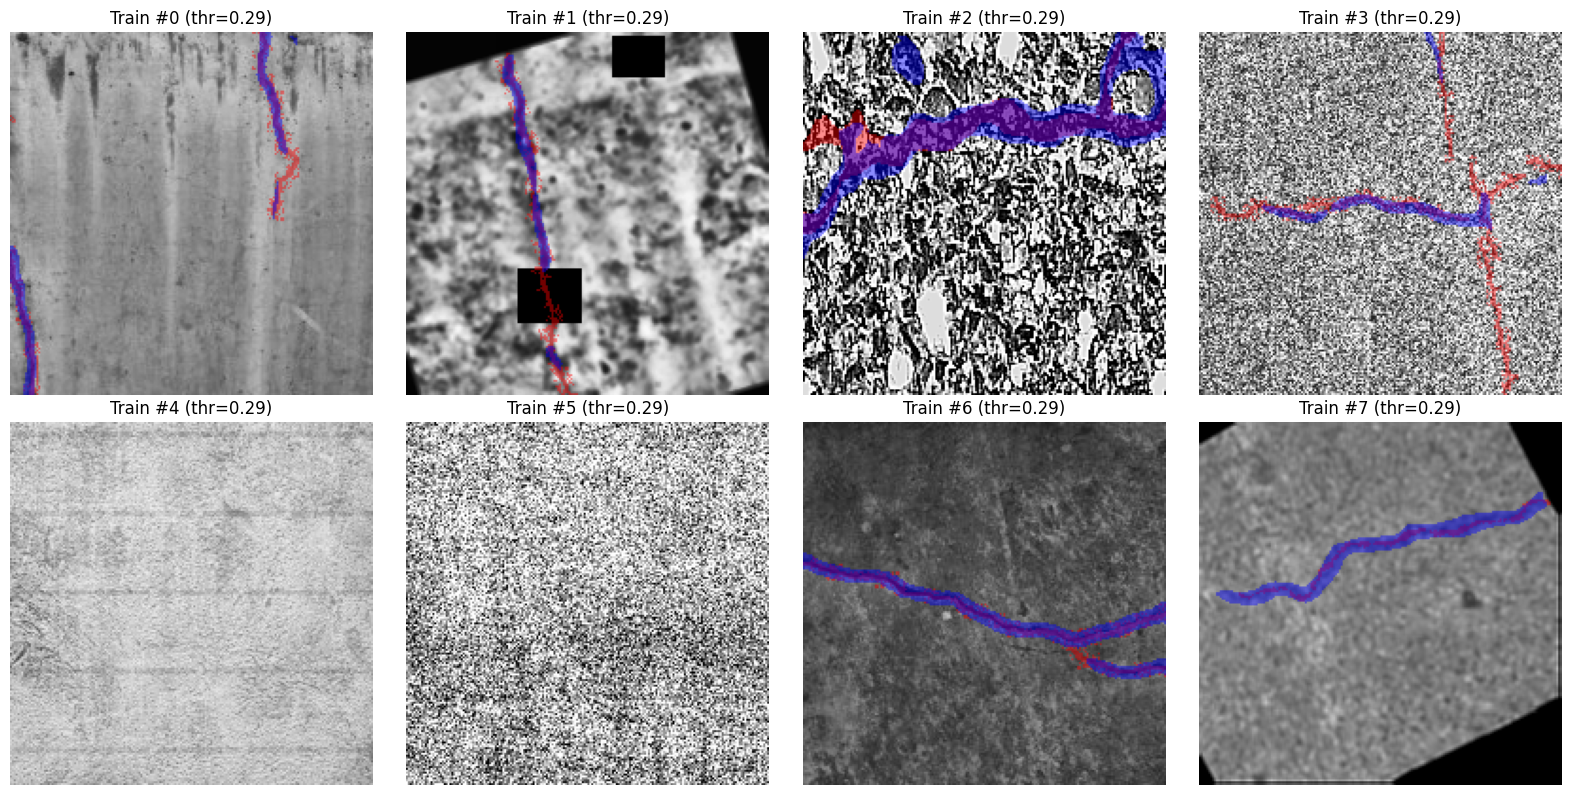

In [25]:
visualize_batch(model, train_loader, device=device, n=8, thresh=best_threshold, save_dir=None, title_prefix="Train")

In [22]:
predict_submit_and_save_masks(
    model=model,
    test_img_dir=TEST_DIR,
    output_csv=OUTPUT_CSV,
    device=device,
    threshold=best_threshold,
    save_masks=True,
    mask_save_dir=OUTPUT_MASK,
    apply_tta=True,
    apply_morphology=True,
    morph_kernel_size=3,
    morph_iterations=2
)


Mask images will be saved to: working/mask_ouputs/predictions_20251018_232929


OK. Submission CSV saved to working/submission.csv, total 2667 rows.
OK. Mask images also saved in: working/mask_ouputs/predictions_20251018_232929
